## Ratajczyk Igor 400513


In [ ]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from typing import Tuple, Any, Dict, List


In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mounted at /content/drive
Num GPUs Available:  1


## General Remarks
Notebook uses cutting edge FensorFlow interface for data augmentation (additional layers inside CNN).

Models were generated in sequential manner: every other iteration corrects the better model from previous comparison.


In [ ]:
INPUT_SHAPE: Tuple[int] = (150, 150, 3)

TRAIN_COUNT: int = 1250
VALIDATION_COUNT: int = 250
TEST_COUNT: int = 250

MODELS_DIR: str = r''
BASE_DIR: str = r''

train_dir: str = os.path.join(BASE_DIR, 'train')
validation_dir: str = os.path.join(BASE_DIR, 'valid')
test_dir: str = os.path.join(BASE_DIR, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [ ]:
def compare_history(
    histories: List[Dict[str, Any]], 
    labels: List[str], 
    epochs: List[int], 
    metric: str = 'accuracy'
    ) -> None:
    # Plot training and validation accuracy per epoch
    
    plt.figure()
    for history, label, epoch in zip(histories, labels, epochs):
        plt.plot(range(epoch), history.history['acc'], label=label+" train")
        plt.plot(range(epoch), history.history['val_acc'], label=label+" validation")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.ylim([0,1.1])
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Loss Plot
    plt.figure()
    for history, label, epoch in zip(histories, labels, epochs):
        plt.plot(range(epoch), history.history['loss'], label=label+" train")
        plt.plot(range(epoch), history.history['val_loss'], label=label+" validation")
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.grid()
    plt.show()



In [ ]:
better_train_generator: Any = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    class_names=["cats", "dogs"],
    color_mode='rgb',
    batch_size=32,
    image_size=INPUT_SHAPE[:2],
    shuffle=True,
    seed=42,
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

better_valid_generator: Any = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    class_names=["cats", "dogs"],
    color_mode='rgb',
    batch_size=32,
    image_size=INPUT_SHAPE[:2],
    shuffle=True,
    seed=42,
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
better_train_generator_eh: Any = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    class_names=["horse", "elephant"],
    color_mode='rgb',
    batch_size=32,
    image_size=INPUT_SHAPE[:2],
    validation_split=0.2,
    shuffle=True,
    seed=42,
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

better_valid_generator_eh: Any = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    class_names=["horse", "elephant"],
    color_mode='rgb',
    batch_size=32,
    image_size=INPUT_SHAPE[:2],
    shuffle=True,
    seed=42,
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 2000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


## Base model

In [ ]:
raw_model: tf.keras.Model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


raw_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [ ]:
raw_model.fit(
    better_train_generator,
    epochs=50,
    validation_data=better_valid_generator,
    verbose = 1
)

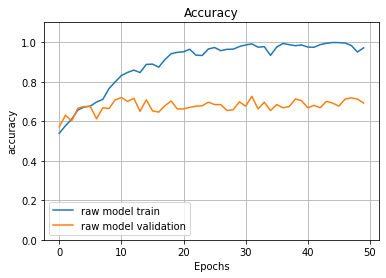

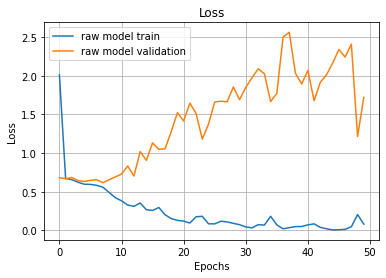

In [ ]:
compare_history([raw_model.history], ["raw model"], [50])

In [ ]:
raw_model.save(os.path.join(MODELS_DIR, "raw_model.h5"))

Results:
- the NN overfits

## Dropout 0.2 Net

In [ ]:
d_model: tf.keras.Model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

d_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [ ]:
d_model.fit(
    better_train_generator,
    epochs=50,
    validation_data=better_valid_generator,
    verbose = 1
)

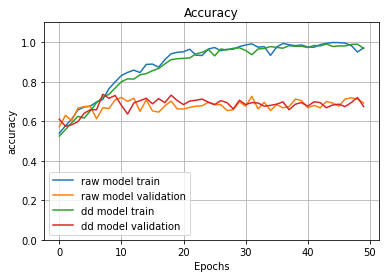

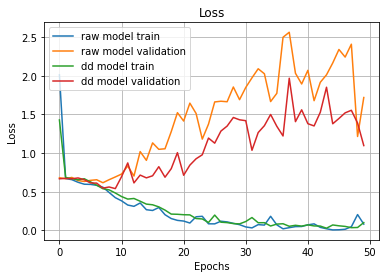

In [ ]:
compare_history([raw_model.history, d_model.history], ["raw model", "dd model"], [50, 50])

In [ ]:
d_model.save(os.path.join(MODELS_DIR, "d_model.h5"))

Results:
-  minor dropout factor barely decreases overfitting


## Rescale

In [ ]:
r_model: tf.keras.Model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1.0/127.5, offset=-1.0),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

r_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [ ]:
r_model.fit(
    better_train_generator,
    epochs=50,
    validation_data=better_valid_generator,
    verbose = 1
)

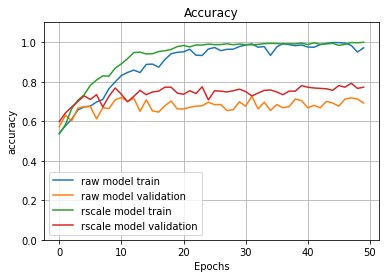

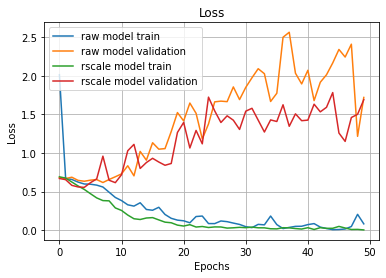

In [ ]:
compare_history([raw_model.history, r_model.history], ["raw model", "rscale model"], [50, 50])

In [ ]:
r_model.save(os.join.path(MODELS_DIR, "r_model.h5"))

Results: 
- rescale decreases overfitting phenomenon


## Random rotation

In [ ]:
rf_model: tf.keras.Model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1.0/127.5, offset=-1.0),
  tf.keras.layers.RandomRotation((-.3,.3), fill_mode='reflect', interpolation='bilinear', fill_value=0.0,),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

rf_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [ ]:
rf_model.fit(
    better_train_generator,
    epochs=50,
    validation_data=better_valid_generator,
    verbose = 1
)

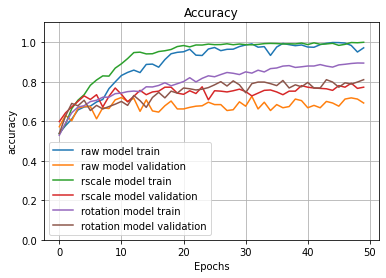

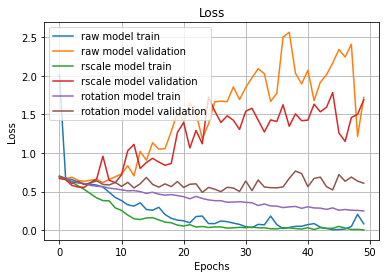

In [ ]:
compare_history([raw_model.history, r_model.history, rf_model.history], ["raw model", "rscale model", "rotation model"], [50, 50, 50])

In [ ]:
rf_model.save(os.join.path(MODELS_DIR, "rf_model.h5"))

Results:
- with additional rotations model no longer overfits

## Deeper Sparse Dense Model

In [ ]:
ddsm_model: tf.keras.Model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1.0/127.5, offset=-1.0),
  tf.keras.layers.RandomRotation((-.3,.3), fill_mode='reflect', interpolation='bilinear', fill_value=0.0,),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

ddsm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [ ]:
ddsm_model.fit(
    better_train_generator,
    epochs=50,
    validation_data=better_valid_generator,
    verbose=0
)

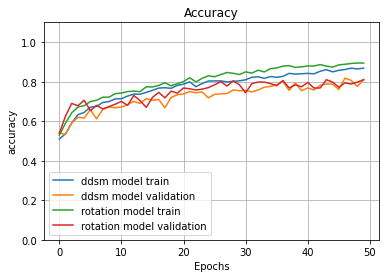

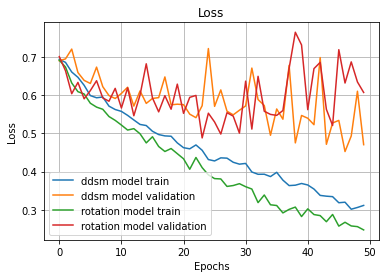

In [ ]:
compare_history([ddsm_model.history, rf_model.history], ["ddsm model", "rotation model"], [50, 50])

In [ ]:
ddsm_model.save(os.join.path(MODELS_DIR, "ddsm_model.h5"))

Results:
- models perform in similar manner

# Random Flip Model

In [ ]:
ddsmf_model: tf.keras.Model = tf.keras.models.Sequential([
  tf.keras.layers.RandomFlip(),
  tf.keras.layers.Rescaling(1.0/127.5, offset=-1.0),
  tf.keras.layers.RandomRotation((-.3,.3), fill_mode='reflect', interpolation='bilinear', fill_value=0.0,),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

ddsmf_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [ ]:
ddsmf_model.fit(
    better_train_generator,
    epochs=50,
    validation_data=better_valid_generator,
    verbose = 0
)

In [ ]:
compare_history([ddsmf_model.history, rf_model.history], ["ddsmf model", "rotation model"], [50, 50])

In [ ]:
ddsmf_model.save(os.join.path(MODELS_DIR, "ddsmf_model.h5"))

## ELU activation

In [ ]:
elu_model: tf.keras.Model = tf.keras.models.Sequential([
  tf.keras.layers.RandomFlip(),
  tf.keras.layers.Rescaling(1.0/127.5, offset=-1.0),
  tf.keras.layers.RandomRotation((-.3,.3), fill_mode='reflect', interpolation='bilinear', fill_value=0.0,),
  tf.keras.layers.Conv2D(32, (3, 3), activation='elu', input_shape=INPUT_SHAPE),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='elu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='elu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='elu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='elu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
elu_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [ ]:
elu_model.fit(
    better_train_generator,
    epochs=50,
    validation_data=better_valid_generator,
    verbose = 1
)

In [ ]:
compare_history([rf_model.history, elu_model.history], ["rotation model", "elu model"], [50, 50])

Results:
- ELU activation for convolutional layers reduces overfitting while slowing the learning process



## Best model for other dataset

In [ ]:
animals_model: tf.keras.Model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1.0/127.5, offset=-1.0),
  tf.keras.layers.RandomRotation((-.3,.3), fill_mode='reflect', interpolation='bilinear', fill_value=0.0,),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

animals_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [ ]:
animals_model.fit(
    better_train_generator_eh,
    epochs=50,
    validation_data=better_valid_generator_eh,
    verbose = 1
)

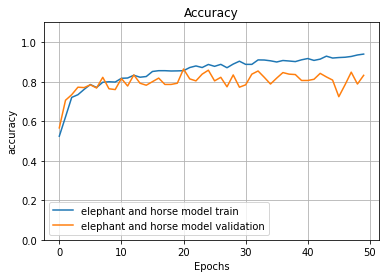

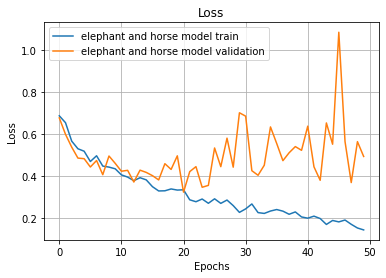

In [ ]:
compare_history([animals_model.history], ["elephant and horse model"], [50])

In [ ]:
animals_model.save(os.path.join(MODELS_DIR, "animals_model.h5"))

Remarks:
- for different dataset model overfits slightly


## General remarks
For small dataset model overfits often, all aforementioned tests were designed to reduce this phenomenon. Data augmentation was the breakthrough. Cutting edge approach with dataset cache allows to speed up the learning process.
